In [1]:
# install packages
!pip install librosa
!pip install matplotlib

In [2]:
# target audio file
audio_path = '../audios/Barn Owl Nestling\'s Adorable Flight Training Session!.mp3'

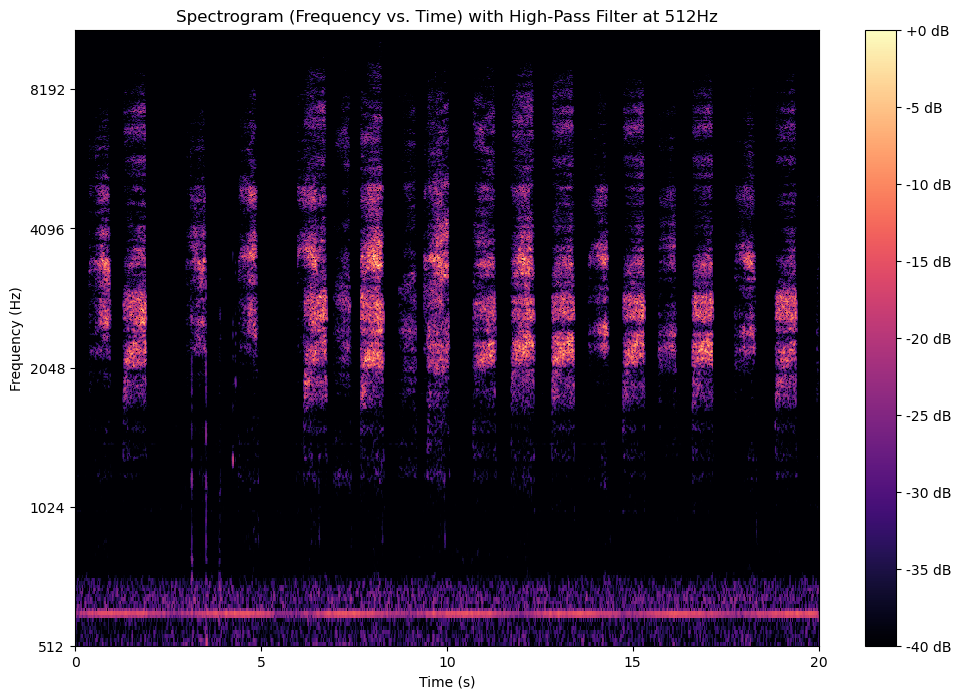

In [7]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

y, sr = librosa.load(audio_path)

# Design a high-pass filter
cutoff_frequency = 512  # 512 Hz
nyquist = 0.5 * sr
normal_cutoff = cutoff_frequency / nyquist
b, a = scipy.signal.butter(1, normal_cutoff, btype='high', analog=False)

y_filtered = scipy.signal.filtfilt(b, a, y)
duration = 20
y_filtered = y_filtered[:duration * sr]
D_filtered = librosa.stft(y_filtered)
S_db_filtered = librosa.amplitude_to_db(np.abs(D_filtered), ref=np.max)

amplitude_threshold = -40

plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db_filtered, sr=sr, x_axis='time', y_axis='log')

plt.ylim(512, sr // 2)

plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (Frequency vs. Time) with High-Pass Filter at 512Hz')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.clim(vmin=amplitude_threshold)  # Set the minimum amplitude to display
plt.show()